### Import Required Libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.
C:\Archivos de programa\Anaconda\envs\tfenv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Archivos de programa\Anaconda\envs\tfenv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Archivos de programa\Anaconda\envs\tfenv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Archivos de programa

In [2]:
import os
os.chdir(r"C:\Users\Marino\Documents\UNIVERSIDAD\MasterBD\AnalisisDatosNoEstructurados\Practica\4_TEXT")
os.getcwd()

'C:\\Users\\Marino\\Documents\\UNIVERSIDAD\\MasterBD\\AnalisisDatosNoEstructurados\\Practica\\4_TEXT'

### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [5]:
data = read_text("deu-eng\deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [6]:
deu_eng = deu_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [7]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['You need not go there.', 'Du musst nicht dorthin gehen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813634 (Pfirsichbaeumchen)'],
       ['You need not go there.', 'Du brauchst nicht dorthin zu gehen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813635 (Pfirsichbaeumchen)'],
       ['You need to apologize.', 'Du musst dich entschuldigen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3826573 (CK) & #3928528 (Tamy)']],
      dtype='<U537')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [8]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [9]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['You need not go there', 'Du musst nicht dorthin gehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813634 (Pfirsichbaeumchen)'],
       ['You need not go there', 'Du brauchst nicht dorthin zu gehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813635 (Pfirsichbaeumchen)'],
       ['You need to apologize', 'Du musst dich entschuldigen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3826573 (CK) & #3928528 (Tamy)']],
      dtype='<U537')

In [10]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [11]:
deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['you need not go there', 'du musst nicht dorthin gehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813634 (Pfirsichbaeumchen)'],
       ['you need not go there', 'du brauchst nicht dorthin zu gehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813635 (Pfirsichbaeumchen)'],
       ['you need to apologize', 'du musst dich entschuldigen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3826573 (CK) & #3928528 (Tamy)']],
      dtype='<U537')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [12]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [13]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.deu))

       eng  deu
0        1    1
1        1    1
2        1    2
3        1    1
4        1    1
...    ...  ...
49995    4    5
49996    5    5
49997    5    5
49998    5    6
49999    4    4

[50000 rows x 2 columns]
7
15


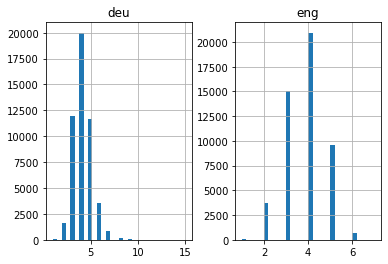

In [14]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [15]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [16]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6331


In [17]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10455


In [18]:
print(deu_tokenizer.word_counts)

OrderedDict([('geh', 155), ('hallo', 34), ('grüß', 3), ('gott', 27), ('lauf', 9), ('potzdonner', 2), ('donnerwetter', 1), ('feuer', 23), ('hilfe', 131), ('zu', 2011), ('hülf', 1), ('stopp', 2), ('warte', 49), ('fang', 15), ('an', 870), ('mach', 199), ('weiter', 125), ('beeil', 11), ('dich', 1045), ('schnell', 178), ('ich', 11453), ('rannte', 48), ('verstehe', 48), ('aha', 2), ('probiere', 6), ('es', 4100), ('hab', 44), ('gewonnen', 70), ('habe', 2131), ('entspann', 6), ('schieß', 3), ('lächeln', 20), ('angriff', 3), ('attacke', 1), ('zum', 160), ('wohl', 53), ('iss', 27), ('auf', 1153), ('keine', 386), ('bewegung', 5), ('stehenbleiben', 2), ('verstanden', 24), ('habs', 9), ('kapiert', 2), ('einverstanden', 35), ('er', 2506), ('lief', 32), ('mit', 670), ('drück', 6), ('mich', 1634), ('nimm', 89), ('in', 861), ('den', 712), ('arm', 60), ('umarme', 2), ('fiel', 31), ('hin', 98), ('stürzte', 6), ('bin', 1878), ('hingefallen', 1), ('gestürzt', 1), ('weiß', 389), ('gelogen', 33), ('verloren'

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [19]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [20]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [21]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   1  109    5 ...    0    0    0]
 [   9    1 1705 ...    0    0    0]
 [   7    3   93 ...    0    0    0]
 ...
 [  11  929   23 ...    0    0    0]
 [   2   68   53 ...    0    0    0]
 [  56 4878    0 ...    0    0    0]]
40000
[[   1  356  113 ...    0    0    0]
 [  22    1  111 ...    0    0    0]
 [  23  207   69 ...    0    0    0]
 ...
 [  12 1086   40 ...    0    0    0]
 [   2   36   61 ...    0    0    0]
 [1286   68    0 ...    0    0    0]]
40000


In [22]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [23]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[   1 2074   27 ...    0    0    0]
 [  11    3 2921 ...    0    0    0]
 [   2   55 3669 ...    0    0    0]
 ...
 [1021    4   56 ...    0    0    0]
 [   5   81    3 ...    0    0    0]
 [  21 1030   18 ...    0    0    0]]
10000
[[   1 2663   58 ...    0    0    0]
 [  12    4    5 ...    0    0    0]
 [   2   24 2845 ...    0    0    0]
 ...
 [  68  543   34 ...    0    0    0]
 [   7   81    4 ...    0    0    0]
 [   3  142    9 ...    0    0    0]]
10000


In [24]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [25]:
from keras.layers import GRU
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(GRU(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(GRU(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [26]:
print(deu_vocab_size)
print(eng_vocab_size)
print(deu_length)
print(eng_length)

10455
6331
8
8


In [27]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [29]:
import time
start_time = time.time()
filename = 'model.GRU'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

print("--- %s seconds ---" % (time.time() - start_time))

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 287s 9ms/step - loss: 2.4785 - val_loss: 2.4988

Epoch 00001: val_loss improved from inf to 2.49884, saving model to model.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 287s 9ms/step - loss: 2.3410 - val_loss: 2.3552

Epoch 00002: val_loss improved from 2.49884 to 2.35520, saving model to model.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 288s 9ms/step - loss: 2.2061 - val_loss: 2.2658

Epoch 00003: val_loss improved from 2.35520 to 2.26580, saving model to model.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 293s 9ms/step - loss: 2.0726 - val_loss: 2.1588

Epoch 00004: val_loss improved from 2.26580 to 2.15884, saving model to model.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 289s 9ms/step - loss: 1.9520 - val_loss: 2.0807

Epoch 00005: val_loss improved from 2.15884 to 2.08072, 

Comprobamos que tal y como se ha estudiado, el modelo con capas GRU (8643.05432009697 seconds) es más rápido en ejecución que el modelo LSTM (9235.729725122452 seconds)


Let's compare the training loss and the validation loss.

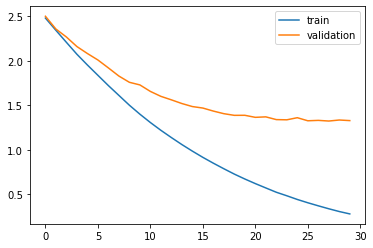

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

También podemos observar cómo se llega antes al valor donde se estabiliza la función de pérdida

### Make Predictions

Let's load the saved model to make predictions.

In [31]:
model = load_model('model.GRU')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [32]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [33]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [34]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [35]:
pd.set_option('display.max_colwidth', 200)

In [36]:
pred_df.head(15)

,actual,predicted
0,tom banged his head,tom brushed his head
1,he is a dj,he is a
2,i like seafood,i like candlelight
3,do it tomorrow,come downstairs
4,do you need the phone,do you need the phone
5,this door wont shut,the door wont open
6,i think youre stupid,i think youre is
7,toms wife just died,toms car is right
8,tom kept winning,tom turned
9,who do you live with,who do you to


In [37]:
pred_df.tail(15)

,actual,predicted
9985,we should be fine,lets should be
9986,i had a bad cold,i got a cold
9987,that might be true,that could be
9988,i dont sleep a lot,i dont eat much
9989,the price is good,the pay is good
9990,come back tomorrow,come again tomorrow
9991,superman can fly,can
9992,go find out,go and do that
9993,your feet are dirty,your feet are dirty
9994,tom is immobile,tom is


In [38]:
pred_df.sample(15)

,actual,predicted
822,how is your father,hows your father
4118,he is alone,hes alone
7200,ill miss that,ill get that
2366,thats what we think,thats what we want
2386,the police were here,the gate was
2474,tom was third in line,tom was in the
877,they can manage,youll be all
6569,stop teasing tom,stop to tom
4424,were in a hurry,were in a fight
4586,whos fasting,who is
